<a href="https://colab.research.google.com/github/neel26desai/data_cleaning_and_eda/blob/main/EDAGraph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Predicting missing link

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import matplotlib.pyplot as plt


## Data Loading

In [1]:
file_path = '/content/drive/MyDrive/facebook_combined.txt'  # Replace with the path to your dataset file
# Let's start by reading the first few lines to understand the structure of the file
with open(file_path, 'r') as file:
    first_lines = [next(file) for _ in range(5)]

first_lines



['0 1\n', '0 2\n', '0 3\n', '0 4\n', '0 5\n']

In [2]:
import networkx as nx

# Load the data into a graph
G = nx.read_edgelist(file_path, nodetype=int)

# Basic information about the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

num_nodes, num_edges


(4039, 88234)

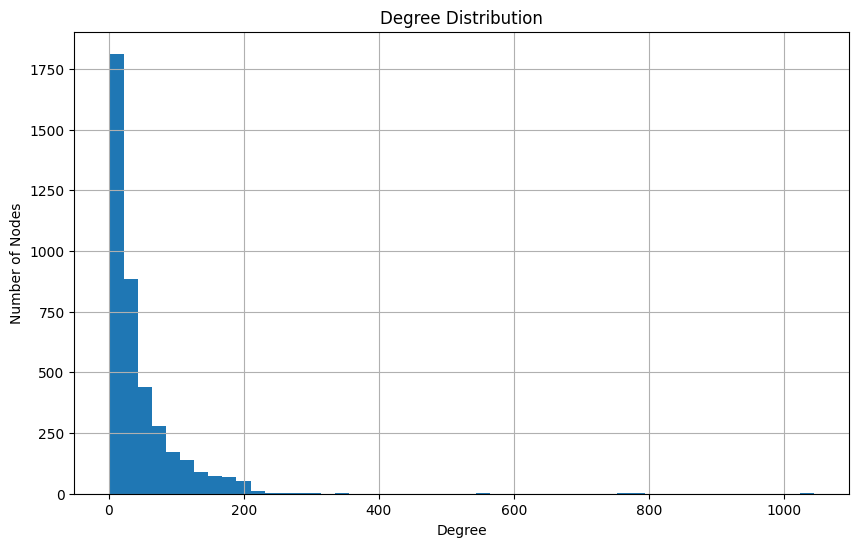

(0.6055467186200876, 0.010819963503439287)

In [5]:


# 1. Degree Distribution
degrees = [G.degree(n) for n in G.nodes()]
plt.figure(figsize=(10, 6))
plt.hist(degrees, bins=50)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True)
plt.show()

# 2. Clustering Coefficient
average_clustering = nx.average_clustering(G)

# 3. Average Shortest Path Length (Note: This might take a long time for large networks)
# average_shortest_path_length = nx.average_shortest_path_length(G)

# 4. Network Density
network_density = nx.density(G)

average_clustering, network_density


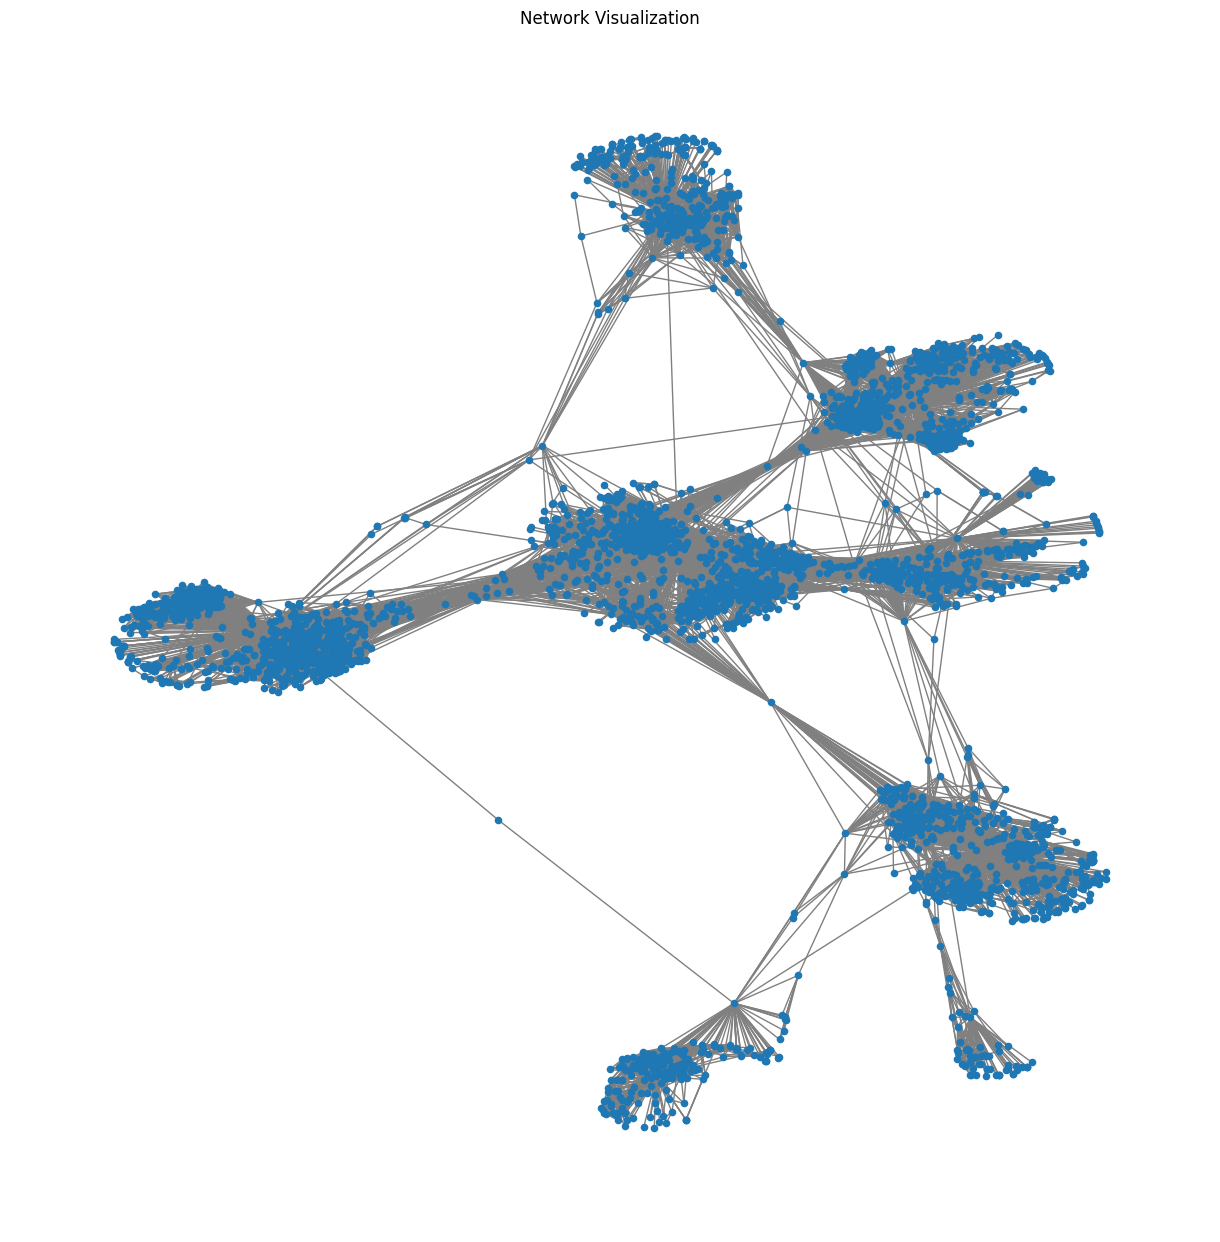

In [6]:
# Visualizing the network
# Given the size of the network, we will use a spring layout for better clarity

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, seed=42)  # Seed for reproducible layout
nx.draw(G, pos, node_size=20, edge_color="grey", with_labels=False)
plt.title("Network Visualization")
plt.show()


## Data Cleaning and Data Preparation

In [7]:
import random

# Number of samples for each class (connected and not connected)
num_samples = 5000

# Create positive examples (pairs of nodes that are connected)
positive_examples = random.sample(G.edges(), num_samples)
positive_labels = [1] * num_samples

# Create negative examples (pairs of nodes that are not connected)
negative_examples = []
while len(negative_examples) < num_samples:
    u, v = random.sample(G.nodes(), 2)
    if not G.has_edge(u, v):
        negative_examples.append((u, v))

negative_labels = [0] * num_samples

# Combine positive and negative examples
examples = positive_examples + negative_examples
labels = positive_labels + negative_labels

# Convert to DataFrame for easier handling
data = pd.DataFrame(examples, columns=['node1', 'node2'])
data['label'] = labels

# Preview the data
data.head()


<ipython-input-7-9b5f76c3d736>:7: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  positive_examples = random.sample(G.edges(), num_samples)
<ipython-input-7-9b5f76c3d736>:13: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  u, v = random.sample(G.nodes(), 2)


,node1,node2,label
0,475,506,1
1,1106,1189,1
2,2153,2555,1
3,1436,1686,1
4,1750,1844,1


In [8]:
# Feature Engineering

# 1. Common Neighbors
data['common_neighbors'] = data.apply(lambda row: len(list(nx.common_neighbors(G, row['node1'], row['node2']))), axis=1)

# 2. Jaccard Coefficient
jaccard_coeffs = [i[2] for i in nx.jaccard_coefficient(G, data[['node1', 'node2']].values.tolist())]
data['jaccard_coefficient'] = jaccard_coeffs

# 3. Adamic-Adar Index
adamic_adar_index = [i[2] for i in nx.adamic_adar_index(G, data[['node1', 'node2']].values.tolist())]
data['adamic_adar_index'] = adamic_adar_index

# 4. Preferential Attachment
preferential_attachment = [i[2] for i in nx.preferential_attachment(G, data[['node1', 'node2']].values.tolist())]
data['preferential_attachment'] = preferential_attachment

# 5. Resource Allocation Index
resource_allocation_index = [i[2] for i in nx.resource_allocation_index(G, data[['node1', 'node2']].values.tolist())]
data['resource_allocation_index'] = resource_allocation_index

# Preview the data with features
data.head()


,node1,node2,label,common_neighbors,jaccard_coefficient,adamic_adar_index,preferential_attachment,resource_allocation_index
0,475,506,1,55,0.395683,13.429166,8784,0.976887
1,1106,1189,1,11,0.203704,3.022589,1026,0.317403
2,2153,2555,1,116,0.734177,24.642424,18765,1.111371
3,1436,1686,1,7,0.120690,1.611349,1050,0.106399
4,1750,1844,1,3,0.015544,0.549816,8820,0.016039


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Split the data into training and test sets
X = data[['common_neighbors', 'jaccard_coefficient', 'adamic_adar_index', 'preferential_attachment', 'resource_allocation_index']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the logistic regression model
model = LogisticRegression(solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

accuracy, conf_matrix, class_report


(0.9625,
 array([[978,  10],
        [ 65, 947]]),
 '              precision    recall  f1-score   support\n\n           0       0.94      0.99      0.96       988\n           1       0.99      0.94      0.96      1012\n\n    accuracy                           0.96      2000\n   macro avg       0.96      0.96      0.96      2000\nweighted avg       0.96      0.96      0.96      2000\n')

In [10]:
accuracy

0.9625